### Description

- In this assignment, I developed a regression model that predicts the number of bikes shared from a Seoul Bike Sharing program.
- The data used is subset of `Seoul Bike Sharing Demand Data Set` in UCI repository sampled by instructor.
- It comprised of 13 features and ranges from `1/12/2017` to `30/11/2018`.
- The final metric used was `r-squared` score.
- I recieved `0.93150` for a public and `0.94145` for a private leaderboard using XGBoost model after fine-tuning the parameters.
- Website: https://www.kaggle.com/competitions/csci-5622-ps4-22-fall/overview

### Importing Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

### EDA

In [4]:
# Reading csv files
XTrain_eda = pd.read_csv('data/XTrain.csv').rename(columns={'Temperature(�C)': 'T', 'Humidity(%)': 'H'
                                                  , 'Wind speed (m/s)':'WS', 'Visibility (10m)':'V'
                                                  , 'Dew point temperature(�C)': 'DP', 'Solar Radiation (MJ/m2)': 'SR'
                                                  , 'Rainfall(mm)': 'R', 'Snowfall (cm)': 'S'
                                                  , 'Functioning Day': 'FD'})
yTrain_eda = pd.read_csv('data/yTrain.csv')
XTest_eda = pd.read_csv('data/XTest.csv').rename(columns={'Temperature(�C)': 'T', 'Humidity(%)': 'H'
                                                  , 'Wind speed (m/s)':'WS', 'Visibility (10m)':'V'
                                                  , 'Dew point temperature(�C)': 'DP', 'Solar Radiation (MJ/m2)': 'SR'
                                                  , 'Rainfall(mm)': 'R', 'Snowfall (cm)': 'S'
                                                  , 'Functioning Day': 'FD'})

In [5]:
XTrain_eda.head()

,Index,Date,Hour,T,H,WS,V,DP,SR,R,S,Seasons,Holiday,FD
0,0,26/04/2018,5,10.2,73,0.8,1137,5.5,0.00,0.0,0.0,Spring,No Holiday,Yes
1,1,2/4/2018,7,15.1,80,1.0,623,11.6,0.01,0.0,0.0,Spring,No Holiday,Yes
2,2,25/05/2018,8,17.1,57,1.7,792,8.5,1.21,0.0,0.0,Spring,No Holiday,Yes
3,3,8/4/2018,22,2.7,88,2.0,621,0.9,0.00,0.0,0.0,Spring,No Holiday,Yes
4,4,6/4/2018,17,6.3,50,4.4,707,-3.3,0.64,0.0,0.0,Spring,No Holiday,Yes


In [6]:
# Handling Date column by chaning it from string to date type
# Used apply/lambda function to handle various date format 
XTrain_eda['Date'] = XTrain_eda['Date'].apply(lambda x: datetime.datetime(int(x.split('/')[2])
                                                                          , int(x.split('/')[1])
                                                                          , int(x.split('/')[0])))
XTest_eda['Date'] = XTest_eda['Date'].apply(lambda x: datetime.datetime(int(x.split('/')[2])
                                                                        , int(x.split('/')[1])
                                                                        , int(x.split('/')[0])))

# Merging XTrain and yTrain data for EDA purpose
Train_eda = pd.merge(XTrain_eda, yTrain_eda, on='Index')
Train_eda = Train_eda.loc[:, Train_eda.columns!='Index']
Test_eda = XTest_eda.loc[:, XTest_eda.columns!='Index']

# Segmenting Date type column into various granuality
# Later, it turned out that seasonality is one of the most important feature for predicting the demands
Train_eda['Day'] = pd.DatetimeIndex(Train_eda['Date']).day
Train_eda['Month'] = pd.DatetimeIndex(Train_eda['Date']).month
Train_eda['Weekday'] = pd.DatetimeIndex(Train_eda['Date']).dayofweek
Test_eda['Day'] = pd.DatetimeIndex(Test_eda['Date']).day
Test_eda['Month'] = pd.DatetimeIndex(Test_eda['Date']).month
Test_eda['Weekday'] = pd.DatetimeIndex(Test_eda['Date']).dayofweek

# Getting rid of the original date type column
Train_eda = Train_eda.loc[:, Train_eda.columns!='Date']
Test_eda = Test_eda.loc[:, Test_eda.columns!='Date']

In [7]:
Train_eda.head()

,Hour,T,H,WS,V,DP,SR,R,S,Seasons,Holiday,FD,Rented Bike Count,Day,Month,Weekday
0,5,10.2,73,0.8,1137,5.5,0.00,0.0,0.0,Spring,No Holiday,Yes,180,26,4,3
1,7,15.1,80,1.0,623,11.6,0.01,0.0,0.0,Spring,No Holiday,Yes,918,2,4,0
2,8,17.1,57,1.7,792,8.5,1.21,0.0,0.0,Spring,No Holiday,Yes,1996,25,5,4
3,22,2.7,88,2.0,621,0.9,0.00,0.0,0.0,Spring,No Holiday,Yes,177,8,4,6
4,17,6.3,50,4.4,707,-3.3,0.64,0.0,0.0,Spring,No Holiday,Yes,776,6,4,4


#### Checking each column
- Determined the preprocessing/transforming method by analyzing a histogram and a line plot.

In [8]:
# Basic statistics of each column
Train_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
Hour,6132.0,11.520059,6.922062,0.0,5.0,12.00,17.00,23.00
T,6132.0,13.002658,11.921261,-17.5,3.5,13.90,22.70,39.30
H,6132.0,58.096053,20.384153,0.0,42.0,57.00,74.00,98.00
WS,6132.0,1.729958,1.045960,0.0,0.9,1.50,2.40,7.30
V,6132.0,1440.791422,606.076776,27.0,946.0,1706.50,2000.00,2000.00
DP,6132.0,4.141813,13.047188,-30.5,-4.7,5.10,14.90,26.80
SR,6132.0,0.578255,0.874270,0.0,0.0,0.01,0.96,3.52
R,6132.0,0.158040,1.227656,0.0,0.0,0.00,0.00,35.00
S,6132.0,0.071836,0.431092,0.0,0.0,0.00,0.00,8.80
Rented Bike Count,6132.0,713.454664,644.588600,0.0,195.0,521.50,1080.00,3556.00


#### Column: Hour

<Axes: xlabel='Hour', ylabel='Count'>

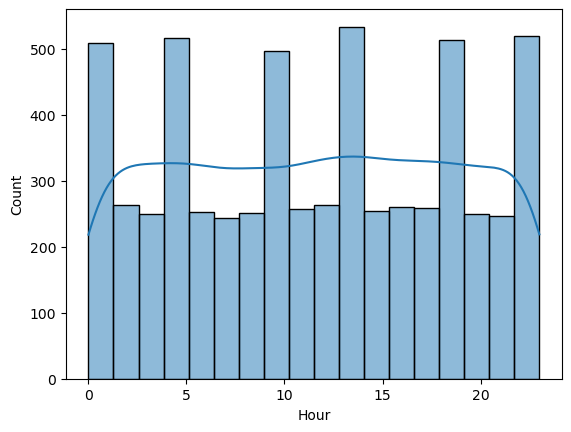

In [9]:
# Hitogram of Column 'Hour'
sns.histplot(Train_eda['Hour'], kde=True)

<Axes: xlabel='Hour', ylabel='Rented Bike Count'>

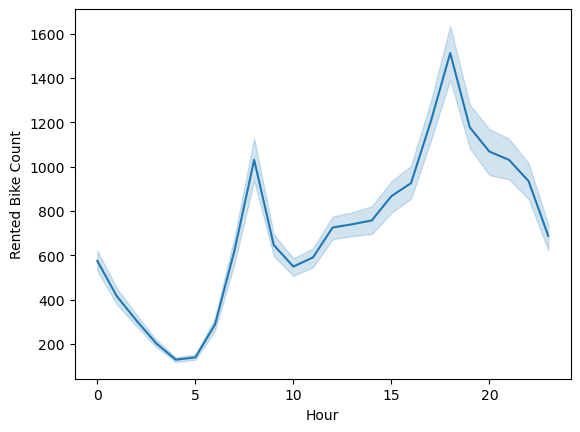

In [10]:
# Line plot of Column 'Hour'
sns.lineplot(data=Train_eda, x="Hour", y="Rented Bike Count")

- Based on the hitogram, the data is pretty well distributed across the day
- Based on the line plot, the number of rented bikes is highly related to the hour of the day
- Instead of using the original data, I encoded the average number of rented bike for each hourly bin

In [11]:
# Encoding the average number of rented bike for each hourly bin
hour_avg = Train_eda[['Hour', 'Rented Bike Count']].groupby('Hour').mean().rename(columns={'Rented Bike Count': 'hour_avg'})
Train_eda['Hour'] = pd.merge(Train_eda, hour_avg, on='Hour', how='left')['hour_avg']
Test_eda['Hour'] = pd.merge(Test_eda, hour_avg, on='Hour', how='left')['hour_avg']

#### Column: Temperature

<Axes: xlabel='T', ylabel='Count'>

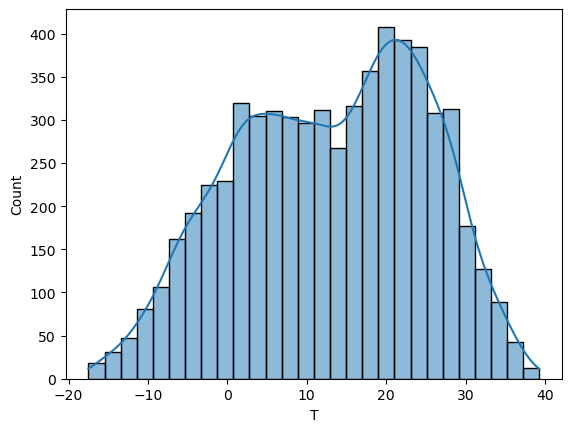

In [12]:
# Hitogram of Column 'T'
sns.histplot(Train_eda['T'], kde=True)

<Axes: xlabel='T', ylabel='Rented Bike Count'>

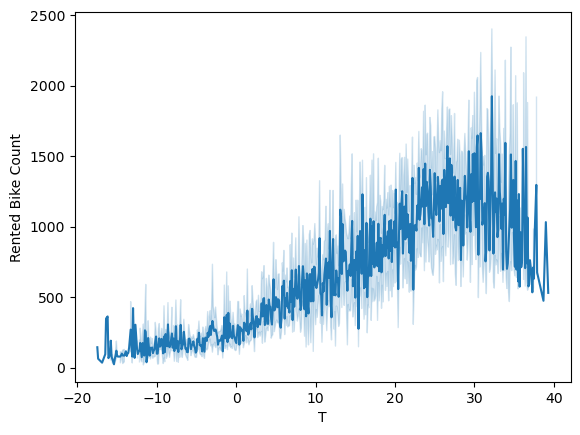

In [13]:
# Line plot of Column 'T'
sns.lineplot(data=Train_eda, x="T", y="Rented Bike Count")

<Axes: xlabel='T', ylabel='Rented Bike Count'>

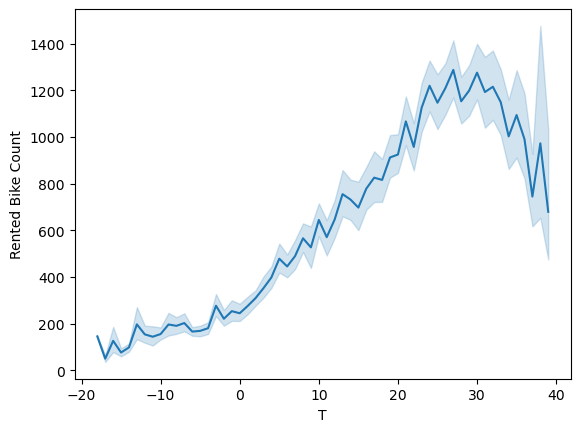

In [14]:
# Line plot of Column 'T' after applying rounding by 1 degree celsius
tmp = Train_eda[['T', 'Rented Bike Count']]
tmp['T'] = round(tmp['T'])
sns.lineplot(data=tmp, x="T", y="Rented Bike Count")

<Axes: xlabel='T', ylabel='Rented Bike Count'>

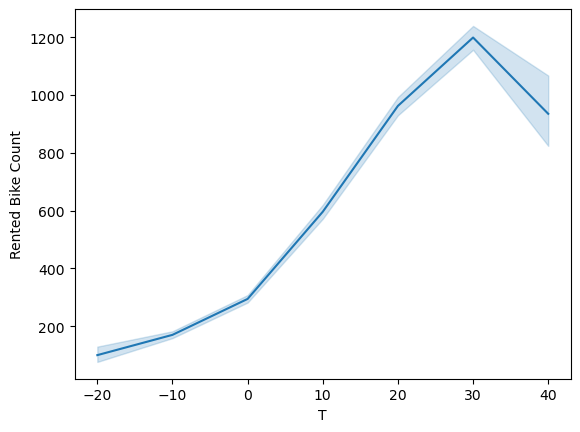

In [15]:
# Line plot of Column 'T' after applying rounding by 10 degree celsius
tmp = Train_eda[['T', 'Rented Bike Count']]
tmp['T'] = round(tmp['T'], -1)
sns.lineplot(data=tmp, x="T", y="Rented Bike Count")

- Based on the histogram, the data is distributed over temperature from -20 to 40 that looks like a bimodal distribution
- Based on the line plot, there seems to be a strong relationship between temperature and the number of bike rented but the variance is high
- So, I applied two types of rounding methods to make variance small and make the prediction more accurate
- When building a model, I tried both rounding methods and chose the first one (i.e. rounding by 1 degree celsius) that showed a better performance on a validation set

In [16]:
# Rounding by 1 degree celsius
Train_eda['T'] = round(Train_eda['T'])
Test_eda['T'] = round(Test_eda['T'])

#### Column: Humidity

<Axes: xlabel='H', ylabel='Count'>

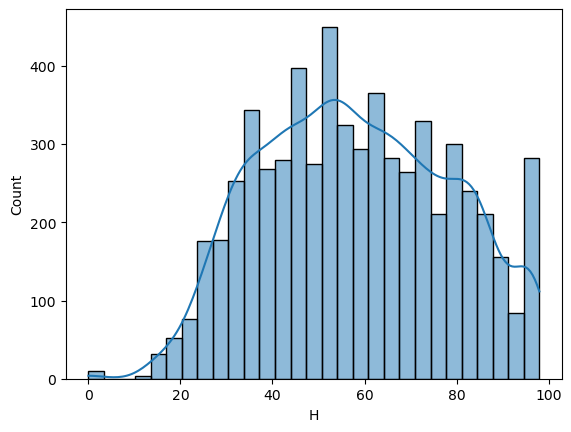

In [17]:
# Hitogram of Column 'H'
sns.histplot(Train_eda['H'], kde=True)

<Axes: xlabel='H', ylabel='Rented Bike Count'>

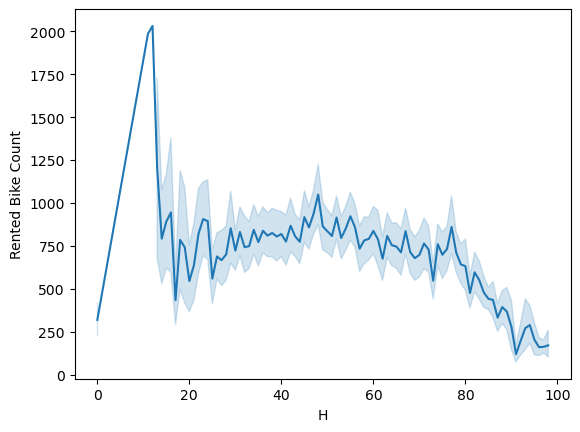

In [18]:
# Line plot of Column 'H'
sns.lineplot(data=Train_eda, x="H", y="Rented Bike Count")

<Axes: xlabel='H', ylabel='Rented Bike Count'>

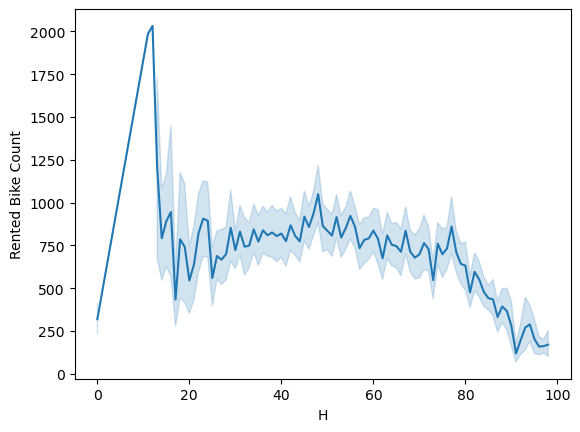

In [19]:
# Line plot of Column 'H' after applying rounding by 1 degree celsius
tmp = Train_eda[['H', 'Rented Bike Count']]
tmp['H'] = round(tmp['H'])
sns.lineplot(data=tmp, x="H", y="Rented Bike Count")

<Axes: xlabel='H', ylabel='Rented Bike Count'>

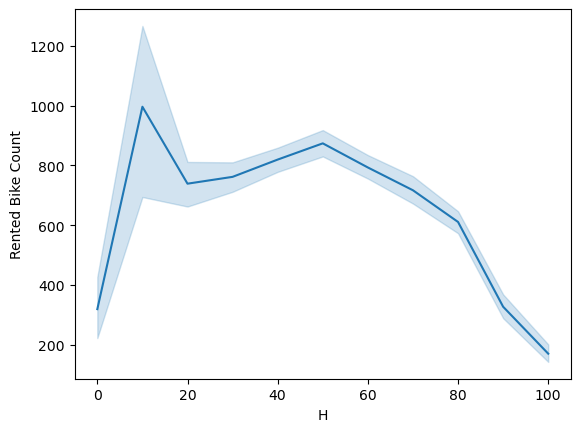

In [20]:
# Line plot of Column 'H' after applying rounding by 10 degree celsius
tmp = Train_eda[['H', 'Rented Bike Count']]
tmp['H'] = round(tmp['H'], -1)
sns.lineplot(data=tmp, x="H", y="Rented Bike Count")

- Based on the histogram, the data is distributed over humidity from 0 to 100 that looks like a unimodal distribution
- Based on the line plot, there seems to be a moderate relationship between humidity and the number of bike rented but the variance is high
- So, I applied two types of rounding methods to make variance small and make the prediction more accurate
- When building a model, I tried both rounding methods and chose the first one (i.e. rounding by 1 degree celsius) that showed a better performance on a validation set

In [21]:
# Rounding by 1 degree celsius
Train_eda['H'] = np.clip(round(Train_eda['H']), a_min=0, a_max=100)
Test_eda['H'] = np.clip(round(Test_eda['H']), a_min=0, a_max=100)

#### Column: Other columns

- I applied similar approach to do EDA on other columns and determined how to preprocess/tranform the original data

<Axes: >

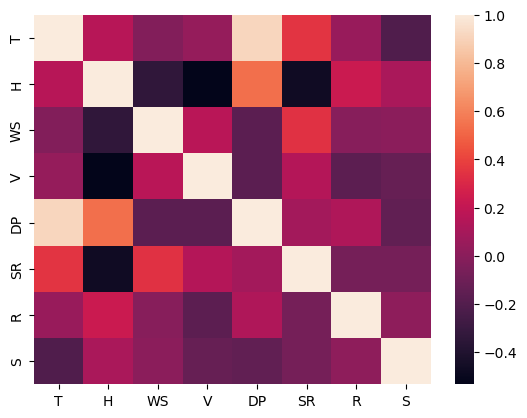

In [22]:
sns.heatmap(XTrain_eda[['T', 'H', 'WS', 'V', 'DP', 'SR', 'R', 'S']].corr())

- In addition, I checked the correlation between columns and decided to remove the column Dew point temperature because it was hight correlated to the column Temperature